Implement this procedure:


- Split the data into an auxiliary sample $D_a$ and a main sample $D_m$.
- Train an honest causal forest $F$ on the auxiliary data $D_a$.
- Take a bootstrap sample $D^BS_m$ from the main sample.
- Compute the SHAP values for the conditional ITT for each instance in $D^BS_m$ using the forest $F$.
- Compute the proportion of instances in $D^BS_m$ for which the SHAP value of age is the largest among all features.
- Repeat steps 3-5 $B$ times and record Q5, the median, and Q95 of the proportions.
- Repeat the procedure for $K$ different splits.

### Imports and set up

In [18]:
import pandas as pd
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
from shap.explainers import _tree # imports local fork

In [19]:
# import data
data = pd.read_csv('jtpa_doubleclean.csv') 

# get X
features = ['afdc', 'sex', 'married', 'pbhous', 'hsorged', 'black', 'hispanic', 'wkless13','age', 'prevearn']
X = data[features + ["assignmt"]]
y = data['earnings']

### Bootstrap implementation

In [36]:
# write auxiliary function for inner bootstrap
def inner_bootstrap(main_sample_X, treeExplainer, n_iterations = 100):

    props = []
    # run inner loop
    for i in tqdm(range(n_iterations)):
        # get bootstrap sample
        bootstrap_sample = main_sample_X.sample(n=main_sample_X.shape[0], replace=True)
        
        # get SHAP values
        shap_values = treeExplainer.shap_values(bootstrap_sample)
        # get proportion of instances where "age" has the largest SHAP value
        prop_age_largest = sum(shap_values.argmax(axis=1) == 8)/shap_values.shape[0]
        props.append(prop_age_largest)
    return props
    

In [37]:
# define outer loop

def outer_loop(data, n_outer = 6, n_inner=100):
    
    results_df = pd.DataFrame()
    
    # run outer loop
    for j in range(n_outer):
        start = time.time()
        # split data randomly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # train model on random split
        causal_forest = CausalForest(min_samples_leaf=4, honest=True)
        causal_forest.fit(X_train[features], X_train['assignmt'], y_train)

        # get treeExplainer
        tE = _tree.TreeExplainer(causal_forest)

        # run inner bootstrap
        results_df[f"Iteration_{j}"] = inner_bootstrap(X_test[features], tE, n_iterations = n_inner)
        end = time.time()
        print(f"Outer loop {j} took {end-start} seconds")
    return results_df

In [38]:
# main loop
results = outer_loop(data, n_outer = 3, n_inner=100)

100%|██████████| 100/100 [10:44<00:00,  6.45s/it]


Outer loop 0 took 644.728954076767 seconds


100%|██████████| 100/100 [10:36<00:00,  6.37s/it]


Outer loop 1 took 637.0084977149963 seconds


100%|██████████| 100/100 [10:28<00:00,  6.29s/it]

Outer loop 2 took 628.8820810317993 seconds


In [39]:
results

,Iteration_0,Iteration_1,Iteration_2
0,0.180829,0.231527,0.219417
1,0.185755,0.219417,0.199302
2,0.182061,0.210796,0.209360
3,0.175287,0.218596,0.200944
4,0.184934,0.221675,0.210386
...,...,...,...
95,0.172414,0.232964,0.208949
96,0.181856,0.229680,0.209154
97,0.184524,0.222701,0.196839
98,0.187603,0.223727,0.207102


In [40]:
results.to_csv("bootstrap_results_age.csv")

### Analysis

In [41]:
# For each iteration, compute the Q5, Q50, Q95
results.quantile([0.05, 0.5, 0.95], axis=0)

,Iteration_0,Iteration_1,Iteration_2
0.05,0.175267,0.217529,0.197229
0.50,0.182574,0.226704,0.208744
0.95,0.189901,0.236884,0.217426


In [42]:
# Now take the median across axis 1
results.quantile([0.05, 0.5, 0.95], axis=0).median(axis=1)

0.05    0.197229
0.50    0.208744
0.95    0.217426
dtype: float64

In [46]:
results.mean(),results.var()

(Iteration_0    0.182890
 Iteration_1    0.226531
 Iteration_2    0.207650
 dtype: float64,
 Iteration_0    0.000022
 Iteration_1    0.000037
 Iteration_2    0.000037
 dtype: float64)

In [45]:
# get mean proportion over its standard error
results.mean(axis=0)/results.std(axis=0)

Iteration_0    39.310650
Iteration_1    37.454464
Iteration_2    33.995062
dtype: float64

(0.1, 0.5)

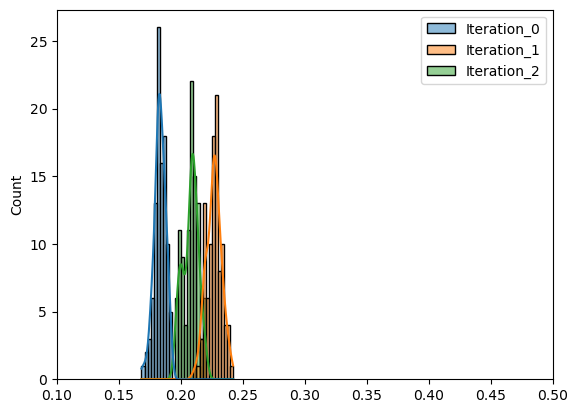

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt


# print distribution of proportions by iteration
sns.histplot(results, kde=True, bins = 30)
plt.xlim(0.1,0.5)

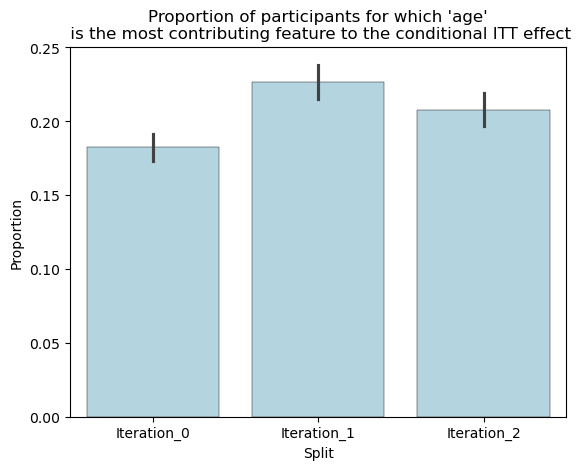

In [79]:
# plot each bar with error bars
sns.barplot(data=results, 
            errorbar=('pi', 95), 
            linewidth = 0.3, color = "lightblue",edgecolor="black")
plt.xlabel("Split")
plt.ylabel("Proportion")
plt.title("Proportion of participants for which 'age'\n is the most contributing feature to the conditional ITT effect")

# save fig
plt.savefig("bootstrap_age.pdf", format = "pdf", dpi = 400)

plt.show()